# Analysis notebook

In this notebook, we will perform a simple data analysis task. Analysis is performed in the following way:
1. Create ntuple with all needed variables (done)
2. Analyse each event, and store the output in a new ntuple
3. Dump the data into histograms/arrays
4. Interpret the results 

The first step is usually done using the CMS Software ([CMSSW](http://cms-sw.github.io/)), and the output is flat ROOT ntuple. The second step can be done either in ROOT using C++ macros or using a jupyter notebook.

The code for event-based analysis has the following structure:
```python
#loop over all events and extract high-level variables
for event in tree:
  do_somthing
  variables['var1']=var1
  ...

#(Optional) Store the variables (example with pandas dataframe)
df = pd.DataFrame(data=variables)
df.to_csv('results.csv', index = False)
```

In [1]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed

Welcome to JupyROOT 6.24/06


In [2]:
#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

In [3]:
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2022/'
#PATH='data'
filename=PATH+'/delphes_GammaGammaMuMu_FPMC_pT25_14TeV_10kEvents.root'

In [4]:
#load the file
tree = uproot.open(filename+":Delphes")

## Analysis of di-muon events

In the following example, we are interested in studying muons coming from the exclusive production mode. Before we start, let's look at the data and count how many muons we have per event:

In [77]:
#obtain N arrays, where N = number of events, and array is an array of muons with pT>25 GeV
muons = tree.arrays(['Muon.PT','Muon.DZ','Muon.Eta','Muon.T','Muon.Phi'], cut = '(Muon.PT>25)')

In [12]:
#for example let's print pT of all muons from the first event:
print(muons['Muon.PT'][0])

[31, 30.6]


In [13]:
#to get the number of muons in event we we will loop over all entries and append length of the muon array:
N = len(muons)
n_muons = []
for i in range(N):
    n_muons.append(len(muons['Muon.PT'][i]))

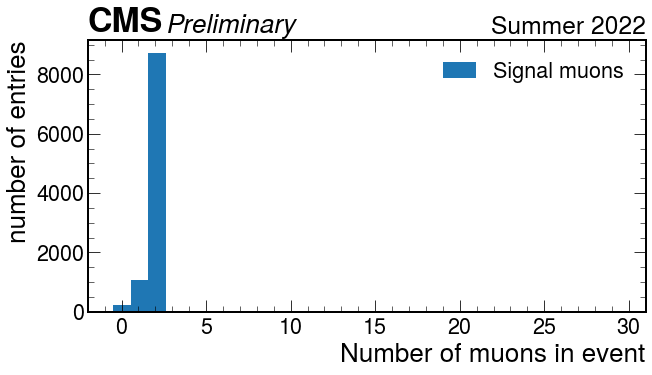

In [22]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(n_muons, bins=np.linspace(-0.5,29.5,30),label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of muons in event', ylabel='number of entries')
plt.savefig('number_muons_signal.png')

As shown in the example above, there are more than two muons in the process $pp\to p \oplus \mu \mu \oplus p$. Where are other muons coming from? To understand it better, let's look at the muon rapidity (or [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity) as muon mass is negligible compare to the momentum):
`muons['Muon.Eta']` is a [awkward.highlevel.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) array with non regular vector size (each event has different number of muons). To plot all muons together we need to use `ak.layout.Content` to make a single array of all muons, and then call `awkward.to_numpy(array)` to convert the output to [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)

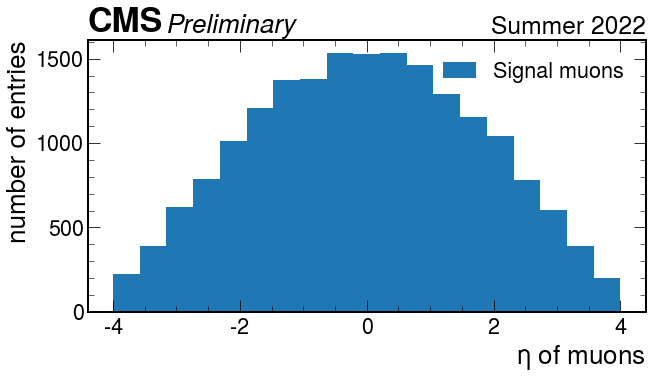

In [15]:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(awkward.to_numpy(muons['Muon.Eta'].layout.content), bins=np.linspace(-4,4,20),label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend(); 
ax.set(xlabel=r'$\eta$ of muons', ylabel='number of entries')
plt.savefig('muon_eta.png')

### Selecting signal muons

Muons originating from pion decay or other pileup interactions are usually very soft. To select signal muons, we will select two opposite sign leading muons. To do it, we need to loop over all events and construct a new dataframe with the relevant information.

In [45]:
N = len(muons) # number of events
print('Number of events = %d'%N)

#select only events with at least two muons:
ev_2muon_idx = [i for i, x in enumerate(muons['Muon.PT']) if len(x)>=2]
N2muon=len(ev_2muon_idx)
print('2 muon filter efficiency = %2.2f'%(N2muon/N))

#define dataframe
data={}
for k in ['pt','eta','phi','m','vz']:
    data['mu1_'+k]=np.zeros(N2muon)
    data['mu2_'+k]=np.zeros(N2muon)

# add  info for di-muon invariant mass
data['mll']=np.zeros(N2muon)

#loop over all events
for i in tqdm(range(N2muon)): 
    
    #loop over all muons in event, and add two muons with higest pT to the data
    mu=muons[ev_2muon_idx[i]]

    #skip events with less than two muons:
    if len(mu['Muon.PT'])<2: continue;
        
    for i_mu, pt in enumerate(mu['Muon.PT']):
        #check if muon has higher pT than mu1_pt
        if pt > data['mu1_pt'][i]:
            #if yes, set mu2=mu1, and update values for mu1
            for k in ['pt','eta','phi','m','vz']:
                data['mu2_'+k][i] = data['mu1_'+k][i]
            data['mu1_pt'][i] = mu['Muon.PT'][i_mu]
            data['mu1_eta'][i] = mu['Muon.Eta'][i_mu]
            data['mu1_phi'][i] = mu['Muon.Phi'][i_mu]
            data['mu1_m'][i] = 0.105 # muon mass
            data['mu1_vz'][i] = mu['Muon.DZ'][i_mu]
        
        #check if muon has higher pT than mu2_pt
        elif pt > data['mu2_pt'][i]:
            #if yes, update values for mu2
            data['mu2_pt'][i] = mu['Muon.PT'][i_mu]
            data['mu2_eta'][i] = mu['Muon.Eta'][i_mu]
            data['mu2_phi'][i] = mu['Muon.Phi'][i_mu]
            data['mu2_m'][i] = 0.105 # muon mass
            data['mu2_vz'][i] = mu['Muon.DZ'][i_mu]
            
    #calculate invariante mass from two muons:
    mu1=ROOT.Math.PtEtaPhiMVector(data['mu1_pt'][i], data['mu1_eta'][i], data['mu1_phi'][i], data['mu1_m'][i])
    mu2=ROOT.Math.PtEtaPhiMVector(data['mu2_pt'][i], data['mu2_eta'][i], data['mu2_phi'][i], data['mu2_m'][i])
    data['mll'][i] = (mu1+mu2).M()

    #print pT of the two leading muons:
    #print('Event=',i,': muons pT = ',muons_anal['mu1_pt'][i],muons_anal['mu2_pt'][i], ' invariant mass = ',muons_anal['mll'][i])
    


Number of events = 10000
2 muon filter efficiency = 0.87


100%|██████████| 8721/8721 [00:13<00:00, 659.21it/s]


In [46]:
#create dataframe
muons_anal = pd.DataFrame(data=data)

Now we will plot the invariant mass of two leptons, and the $\eta$ distribution of signal leptons:

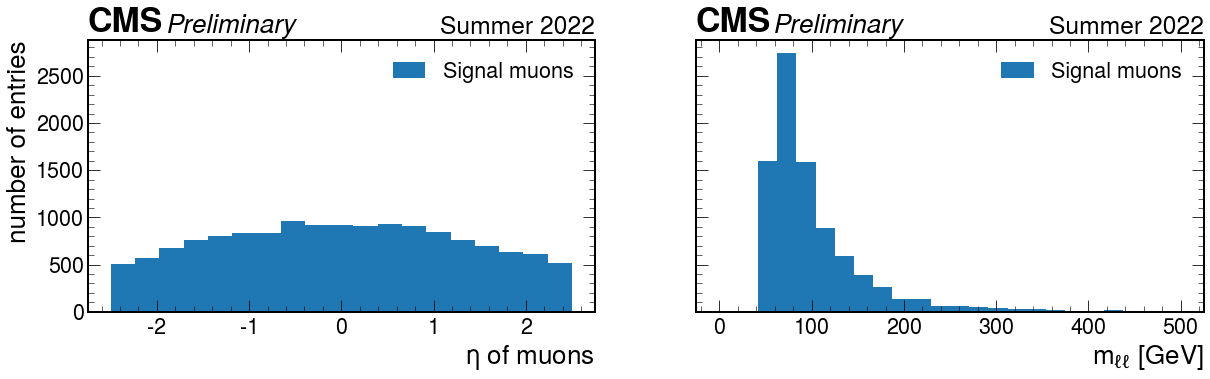

In [47]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
ax[0].hist(np.concatenate([muons_anal['mu1_eta'].values,muons_anal['mu2_eta'].values]), bins=np.linspace(-2.5,2.5,20),label='Signal muons')
ax[0].set(xlabel=r'$\eta$ of muons', ylabel='number of entries')

ax[1].hist(muons_anal['mll'].values, bins=np.linspace(0,500,25),label='Signal muons')
ax[1].set(xlabel=r'$m_{\ell\ell}$ [GeV]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax[i])
    ax[i].legend()
plt.savefig('dimuon_analysis.png')

NOTE: the low $m_{\ell\ell}$ entries are from backgound muons, easy to see it using 2D scatter plot between leading muon $p_T$ and invariant mass:

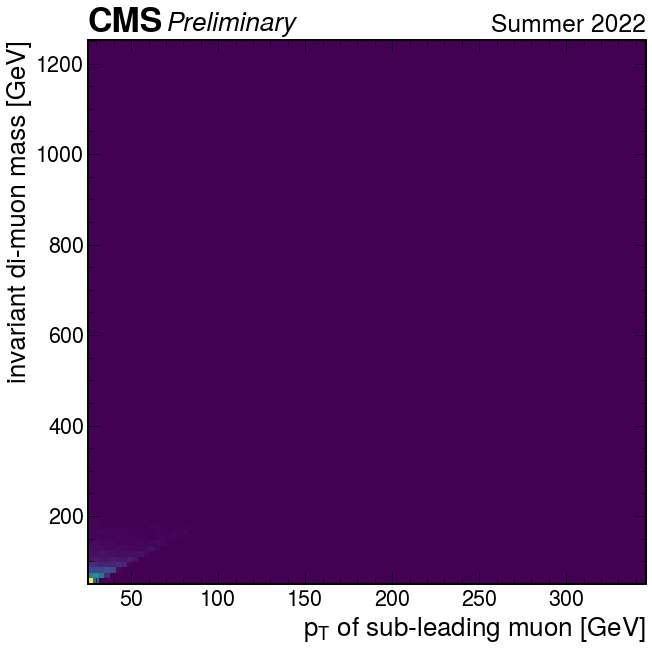

In [48]:
fig, axes = plt.subplots(figsize=(10,10) )
axes.hist2d( muons_anal['mu2_pt'].values, muons_anal['mll'].values, bins=(100,100) , cmap='viridis')
axes.set(xlabel=r'$p_T$ of sub-leading muon [GeV]', ylabel='invariant di-muon mass [GeV]')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=axes)
plt.savefig('dimuon_analysis_correlation.png')

### Event variables and signal muons

In the next cell, we will plot the correlation between the time measured for each one of the muons and the actual time the collision happens (`genvtx_t0`).

In [60]:
#get the event info:
event_info = tree.arrays(['GenProton.T'])
vertex_info = tree.arrays(['Vertex.T','Vertex.Z'])

inspect proton time information (note the units - seconds)

In [61]:
event_info

<Array [{'GenProton.T': [-1.33e-10, ... ] type='10000 * {"GenProton.T": var * fl...'>

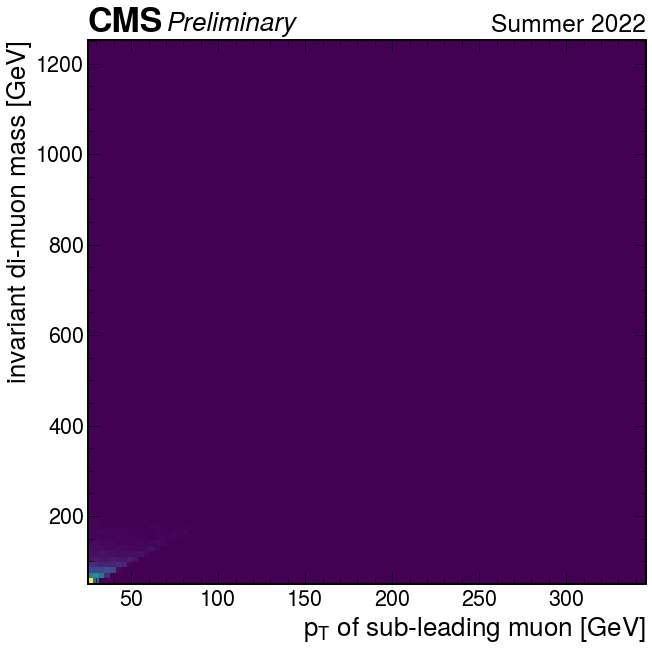

In [81]:
fig, axes = plt.subplots(figsize=(10,10) )
axes.hist2d( muons_anal['mu2_pt'].values, muons_anal['mll'].values, bins=(100,100) , cmap='viridis')
axes.set(xlabel=r'$p_T$ of sub-leading muon [GeV]', ylabel='invariant di-muon mass [GeV]')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=axes)
plt.savefig('dimuon_analysis_correlation.png')

We copy-paste the analysis cell here, adding event info to the dataframe:

In [91]:
N = len(muons) # number of events

#select only events with at least two muons:
ev_2muon_idx = [i for i, x in enumerate(muons['Muon.PT']) if len(x)>=2]
N2muon=len(ev_2muon_idx)

#define dataframe
data={}
for k in ['pt','eta','phi','m','t','vz']:
    data['mu1_'+k]=np.zeros(N2muon)
    data['mu2_'+k]=np.zeros(N2muon)

# add  info for di-muon invariant mass
data['mll']=np.zeros(N2muon)
data['evt_t0']=np.zeros(N2muon)
data['vtx_t0']=np.zeros(N2muon)

#loop over all events
for i in tqdm(range(N2muon)): 
    
    #loop over all muons in event, and add two muons with higest pT to the data
    mu=muons[ev_2muon_idx[i]]
    ev=event_info[ev_2muon_idx[i]]
    vertex=vertex_info[ev_2muon_idx[i]]
    
    #skip events with less than two muons:
    if len(mu['Muon.PT'])<2: continue;
        
    for i_mu, pt in enumerate(mu['Muon.PT']):
        #check if muon has higher pT than mu1_pt
        if pt > data['mu1_pt'][i]:
            #if yes, set mu2=mu1, and update values for mu1
            for k in ['pt','eta','phi','m','t','vz']:
                data['mu2_'+k][i] = data['mu1_'+k][i]
            data['mu1_pt'][i] = mu['Muon.PT'][i_mu]
            data['mu1_eta'][i] = mu['Muon.Eta'][i_mu]
            data['mu1_phi'][i] = mu['Muon.Phi'][i_mu]
            data['mu1_m'][i] = 0.105 # muon mass
            data['mu1_t'][i] = mu['Muon.T'][i_mu] / 1e-9
            data['mu1_vz'][i] = mu['Muon.DZ'][i_mu]
            
        #check if muon has higher pT than mu2_pt
        elif pt > data['mu2_pt'][i]:
            #if yes, update values for mu2
            data['mu2_pt'][i] = mu['Muon.PT'][i_mu]
            data['mu2_eta'][i] = mu['Muon.Eta'][i_mu]
            data['mu2_phi'][i] = mu['Muon.Phi'][i_mu]
            data['mu2_m'][i] = 0.105 # muon mass
            data['mu2_t'][i] = mu['Muon.T'][i_mu] / 1e-9
            data['mu2_vz'][i] = mu['Muon.DZ'][i_mu]
            
    #calculate invariante mass from two muons:
    mu1=ROOT.Math.PtEtaPhiMVector(data['mu1_pt'][i], data['mu1_eta'][i], data['mu1_phi'][i], data['mu1_m'][i])
    mu2=ROOT.Math.PtEtaPhiMVector(data['mu2_pt'][i], data['mu2_eta'][i], data['mu2_phi'][i], data['mu2_m'][i])
    data['mll'][i] = (mu1+mu2).M()
    
    #add event info variables:
    data['evt_t0'][i]=ev['GenProton.T'][0]/1e-9
    data['vtx_t0'][i]=vertex['Vertex.T'][0]/1e-9

100%|██████████| 8721/8721 [00:15<00:00, 566.40it/s]


In [92]:
#create dataframe
analysis = pd.DataFrame(data=data)

### Muon timing information

Muons time hits computed from the future MIP Timing Detector (MTD) are calculated in the detector reference and need to be corrected to the primary vertex reference. Here we will show the correlation between muon time and muon eta. At this step, we will not use muon timings (only the vertex timing), so we will not develop corrections.

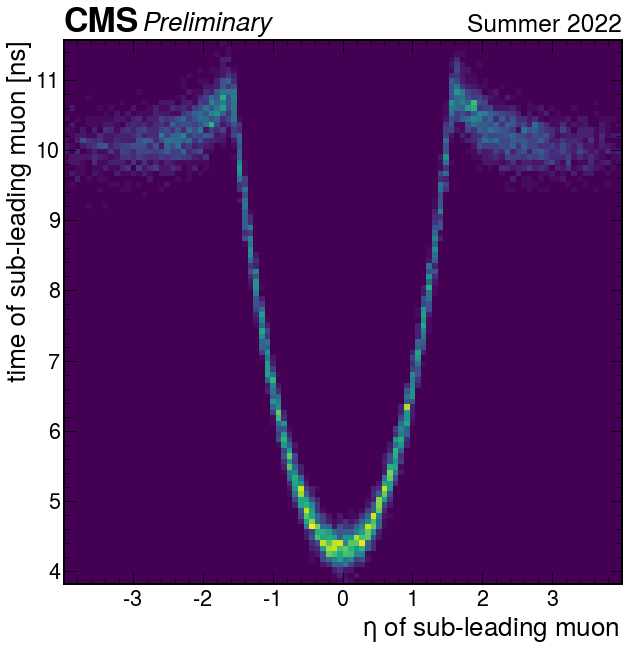

In [96]:
fig, axes = plt.subplots(figsize=(10,10) )
axes.hist2d( analysis['mu2_eta'].values, analysis['mu2_t'].values,  bins=(100,100) , cmap='viridis')
axes.set(xlabel=r'$\eta$ of sub-leading muon ', ylabel=' time of sub-leading muon [ns]')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=axes)
plt.savefig('dimuon_analysis_correlation.png')

Hence, we will use vertex time instead of the muon times (the next plots need to be updated)

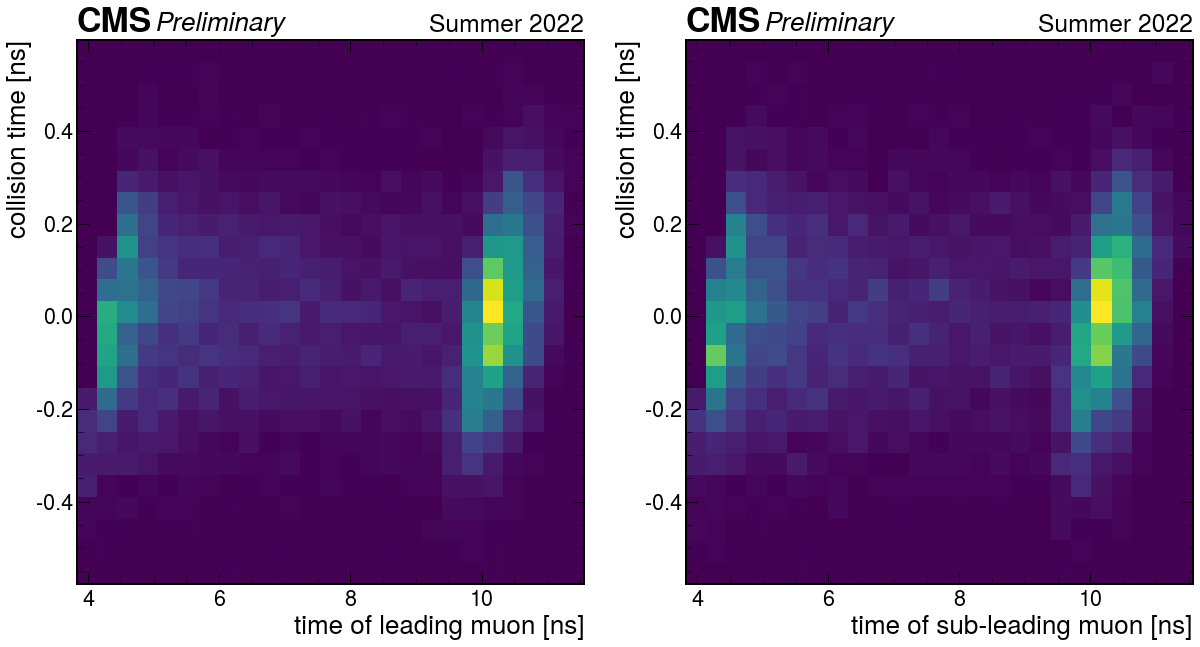

In [97]:
#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
axes[0].hist2d( analysis['mu1_t'].values, analysis['evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[0].set(xlabel='time of leading muon [ns]', ylabel='collision time [ns]')

axes[1].hist2d( analysis['mu2_t'].values, analysis['evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[1].set(xlabel='time of sub-leading muon [ns]', ylabel='collision time [ns]')

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=axes[i])
plt.savefig('dimuon_analysis_time_correlation.png')

NOTE: some muons don't have reconstructed time, therefore their `t=-99` When working with pandas dataframe it useful to **mask** events (filter) before plotting:

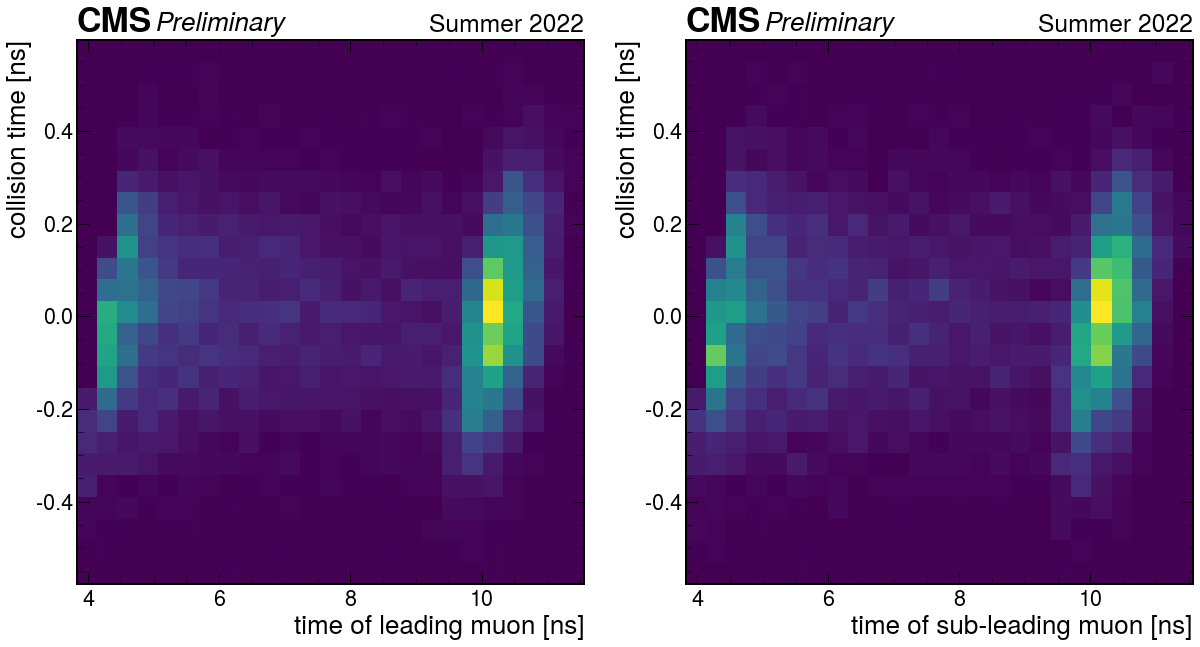

In [98]:
mask_muon1_measured_time = analysis['mu1_t']>-80
mask_muon2_measured_time = analysis['mu2_t']>-80

#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
masked_analysis=analysis[mask_muon1_measured_time]
axes[0].hist2d( masked_analysis['mu1_t'].values, masked_analysis['evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[0].set(xlabel='time of leading muon [ns]', ylabel='collision time [ns]')

masked_analysis=analysis[mask_muon2_measured_time]
axes[1].hist2d( masked_analysis['mu2_t'].values, masked_analysis['evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[1].set(xlabel='time of sub-leading muon [ns]', ylabel='collision time [ns]')

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=axes[i])
plt.savefig('dimuon_analysis_time_correlation2.png')

### MIP Timining Detector (MTD) resolution

In the following cell we will plot the MTD timing resolution as obtained from the simulation. Resoluiton is measured in percent (%) and defined by the standard variation of the difference between recontructed and true values:
$ \sigma^2 = \frac{1}{N-1}\Sigma \left(t_{rec} - t_{true}\right)^2 $

In [99]:
recontsructed_time_resolution1 = analysis[mask_muon1_measured_time]['mu1_t'].values - analysis[mask_muon1_measured_time]['evt_t0'].values
recontsructed_time_resolution2 = analysis[mask_muon2_measured_time]['mu2_t'].values - analysis[mask_muon2_measured_time]['evt_t0'].values
recontsructed_time_resolution = np.concatenate([recontsructed_time_resolution1,recontsructed_time_resolution2]) #add two arrays together

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:366: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:371: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


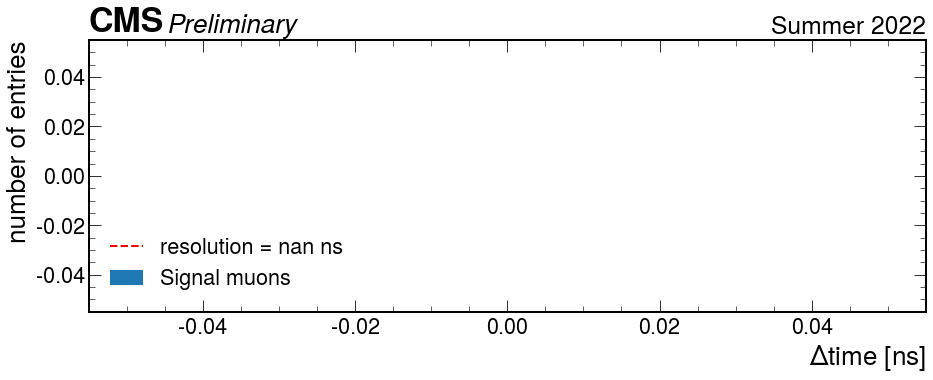

In [104]:
f, ax = plt.subplots(figsize=(15,5))
bins=np.linspace(-2,2,50)
ax.hist(recontsructed_time_resolution, bins=bins,density=True,label='Signal muons')
ax.set(xlabel=r'$\Delta time$ [ns]', ylabel='number of entries')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):
(mu, sigma) = stats.norm.fit(recontsructed_time_resolution[(recontsructed_time_resolution<max(bins)) & (recontsructed_time_resolution>min(bins))])
x=np.linspace(min(bins),max(bins),200)
y=stats.norm.pdf(x, mu, sigma) # * (bins[1]-bins[0]) * len(recontsructed_time_resolution[(recontsructed_time_resolution>min(bins))&(recontsructed_time_resolution<max(bins))])
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2022", ax=ax)
ax.legend()
plt.savefig('MTD_resolution.png')